In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import emcee
from scipy.optimize import minimize
import corner
import random
from IPython.display import display, Math

In [2]:
data = np.load('transient.npy') 
#first column is time, the second column is the flux, and the third column are homoescedastic measurement uncertainties on the flux

In [3]:
time = data[:, 0]
flux = data[:, 1]
err_flux = data[:, 2]

Text(0, 0.5, 'flux')

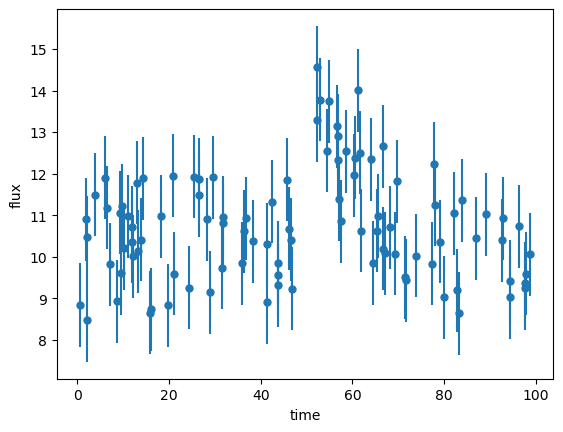

In [4]:
plt.figure(dpi = 100)
plt.errorbar(time, flux, yerr=err_flux, fmt='o', ms=5)
plt.xlabel('time')
plt.ylabel('flux')

In [5]:
#sharp burst with an exponential tail rising above a nominal background level.
def model_burst(t, theta):
    b, A, t0, alpha = theta
    result = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
    return result
 
tgrid=np.linspace(0,100,1000)
b_fit=10.2
A_fit=4.6
t0_fit=50
alpha_fit=0.13

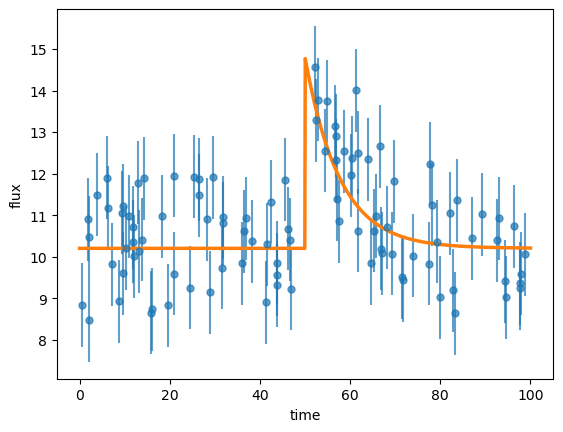

In [6]:
theta_fit= np.array([b_fit,A_fit,t0_fit,alpha_fit])
ygrid =  model_burst(tgrid, theta_fit)
plt.errorbar(time, flux, yerr=err_flux, alpha=0.7, fmt='o', ms=5)
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid,ygrid,lw=2.5)

plt.show()  

In [7]:
#likelihood(f,t|b, A, t0, alpha) = product*0.5* exp(-(f-model(t|b, A, t0, alpha)^2)/sigma^2) 
def log_likelihood(theta, x, y, sigma, model = model_burst):
    b, A, t0, alpha = theta
    return -0.5 * np.sum((y - model(x,theta)) ** 2 / sigma**2)
#PRIORS
def log_prior(theta):
    b, A, t0, alpha = theta
    if 0.0 < b < 50.0 and 0.0 < A < 50.0 and 0.0 < t0 < 100.0 and np.exp(-5) < alpha < np.exp(5):
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    return -np.inf    
#POSTERIOR probability samples for the joint parameter space
def log_posterior(theta, x, y, sigma, model = model_burst):
    b, A, t0, alpha = theta
    return log_prior(theta) + log_likelihood(theta, x, y, sigma, model)

ndim= 4 # paramenters in the model: b, A, t0, alpha
nwalkers= ndim*9 


In [8]:
initial_guesses = np.array([theta_fit + 0.1 * np.random.randn(ndim) for _ in range(nwalkers)]) #adding some random noise
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[time, flux, err_flux,model_burst ])
sampler.run_mcmc(initial_guesses, 10000);

C:\Users\Asus\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


(10000, 36, 4)


<Figure size 768x576 with 0 Axes>

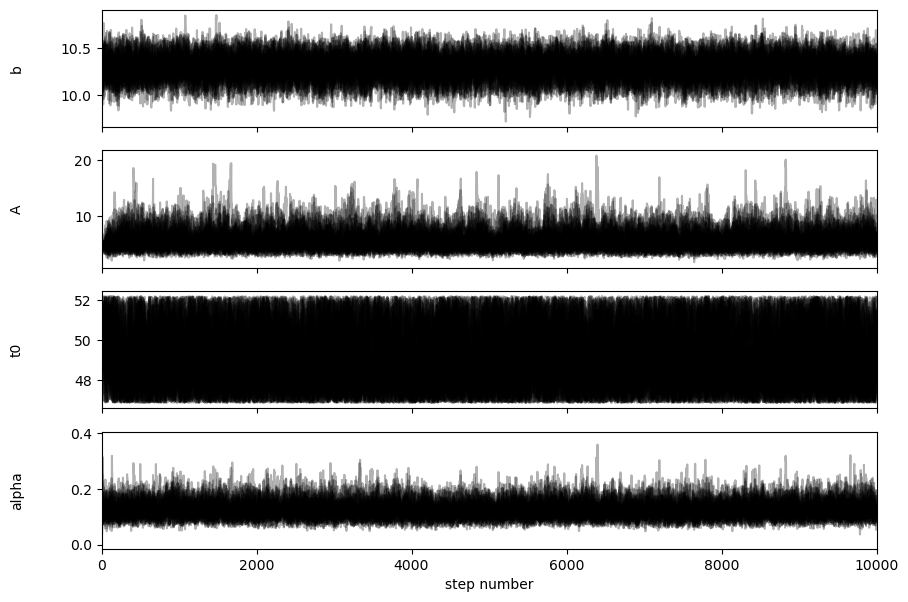

In [9]:
plt.figure(dpi = 120)
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["b", "A", "t0", "alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [10]:
autocorr= sampler.get_autocorr_time()#auto-correlation length represents how long it takes for the chain to become uncorrelated with itself.
                                    #If you have a high auto-correlation length, you’ll need to keep fewer samples to achieve independence between them.
                                    #This suggests that only about 54-71-68-54 steps are needed for the chain to “forget” where it started.
                                    #autocorr(Tau) represents how many steps it takes for the chain to lose correlation with its previous state.
print(autocorr)
#thinning
flat_samples = sampler.get_chain(discard=2000, thin=int(max(autocorr)), flat=True) #Discard the first 10% to 30% of samples as burn-in (they are 10000).(20%?)
print(flat_samples.shape)

[55.22768448 71.87246653 76.24567869 59.76304922]
(3780, 4)


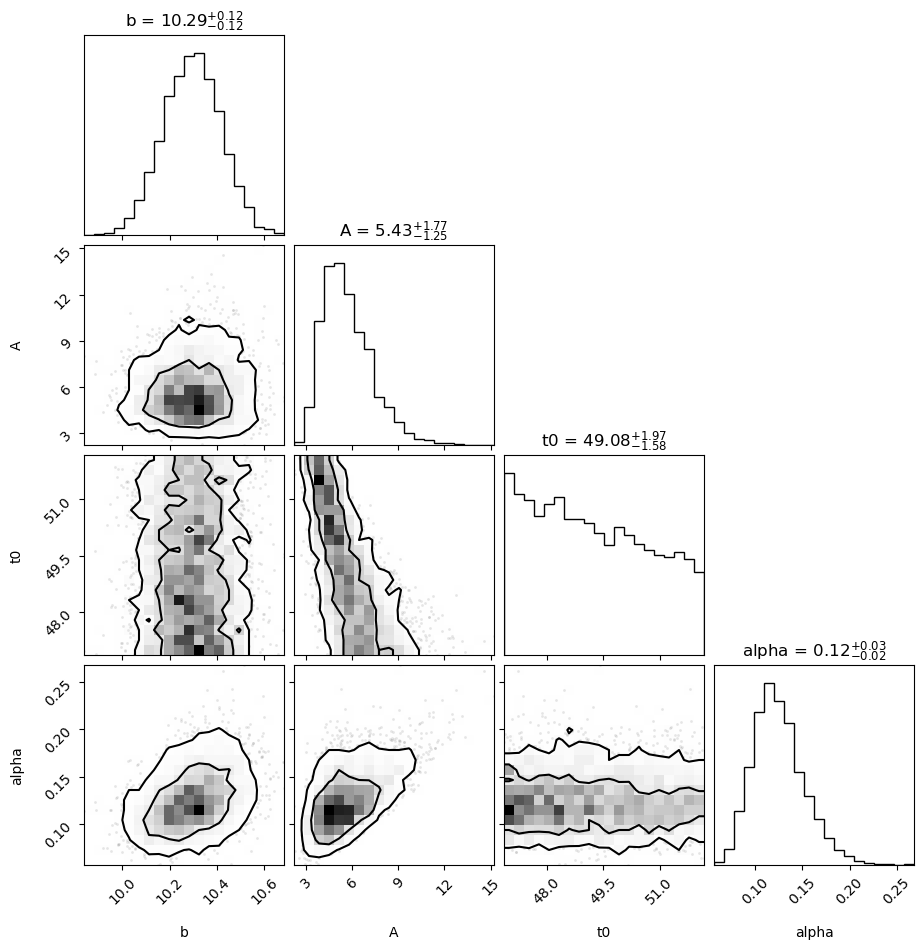

In [11]:
#corner plot 4D [68,95]% credible levels and quantiles
fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68,0.95], show_titles=True,title_kwargs={"fontsize": 12},
);

Now I choose 100 samples randomly from my burned, thinned chain and plot the 100 corresponding burst time-series on a figure along with the original data. These are showing the posterior spread of model solutions that are consistent with the data.

Text(0, 0.5, 'flux')

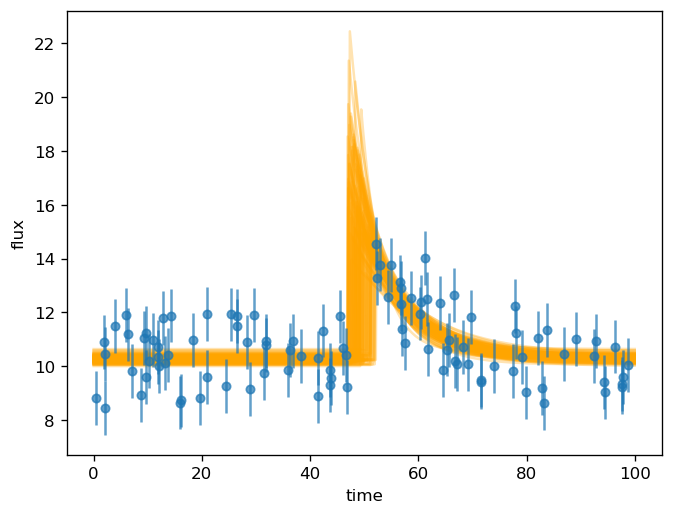

In [12]:
sel_samples = flat_samples[np.random.choice(len(flat_samples), size=100)]
plt.figure(dpi = 120)
tgrid=np.linspace(0,100,1000)
for s in sel_samples:
    plt.plot(tgrid,model_burst(tgrid, s),alpha=0.3,c='orange')

plt.errorbar(time, flux, yerr=err_flux, alpha=0.7, fmt='o', ms=5)
plt.xlabel('time')
plt.ylabel('flux')

In [13]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 25, 50, 75, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The values got by marginalization cannot be use as good estimation of the problem (fit of the distribution) because to get them 
I compressed the 4 dimensions into 1, doing the median of histograms of every parameter, putting them together has no sense